<a href="https://colab.research.google.com/github/GabrielFePL/Sugestao-de-Noticia-LSTM/blob/main/Estudo03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural Recorrente para Predição de Notícias Sugeridas

## Base de Dados Histórica Simulada

### Importação das Bibliotecas

In [201]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

### Função de Geração da Base de Dados e Registros

In [202]:
def generate_simulated_data(num_users, num_access, num_subcategories, start_date):
  data = []

  # Definir preferências por subcategorias para cada usuário
  user_preferences = {user_id: random.choices(range(1, num_subcategories+1), k=num_subcategories) for user_id in range(1, num_users+1)}

  # Definir perfil de horário de cada usuário
  user_profile = {user_id: random.choice(['morning', 'afternoon', 'evening', 'night']) for user_id in range(1, num_users+1)}

  morning_hours = list(range(6, 12))
  afternoon_hours = list(range(12, 18))
  evening_hours = list(range(18, 24))
  night_hours = list(range(0, 6))

  accesses_per_user = num_access // num_users

  for i in range(1, num_users + 1):
    user_id = i

    # Ajustar horários com base no perfil do usuário
    profile = user_profile[user_id]
    if profile == 'morning':
      time_slots = morning_hours * 4 + evening_hours * 2 + afternoon_hours * 1 + night_hours * 1
    elif profile == 'afternoon':
      time_slots = afternoon_hours * 4 + evening_hours * 2 + morning_hours * 1 + night_hours * 1
    elif profile == 'evening':
      time_slots = evening_hours * 4 + morning_hours * 2 + afternoon_hours * 1 + night_hours * 1
    else:
      time_slots = night_hours * 4 + evening_hours * 2 + afternoon_hours * 1 + morning_hours * 1

    current_timestamp = start_date

    for r in range(accesses_per_user):
      # Probabilidade maior de acessar subcategorias favoritas
      subcategory_id = random.choices(user_preferences[user_id], weights=[0.4 if sc == user_preferences[user_id][0] else 0.3 for sc in user_preferences[user_id]], k=1)[0]

      # Simulação de horários com mais acessos
      hour_bias = random.choices(time_slots, k=1)[0]
      current_timestamp = current_timestamp.replace(hour=hour_bias, minute=random.randint(0, 59))

      month = current_timestamp.month
      day = current_timestamp.day
      hour = current_timestamp.hour
      minute = current_timestamp.minute
      day_of_week = current_timestamp.weekday()

      data.append([user_id, subcategory_id, current_timestamp, month, day, hour, minute, day_of_week])

      current_timestamp += timedelta(days=random.randint(1, 3), hours=random.randint(0, 5))

  columns = ['User_ID', 'Subcategory_ID', 'Current_Timestamp', 'Time_Component_Month', 'Time_Component_Day', 'Time_Component_Hour', 'Time_Component_Minute', 'Time_Component_Day_of_Week']
  df = pd.DataFrame(data, columns=columns)

  return df

### Geração da Base de Dados

In [203]:
# Definição da Simulação
num_users = 2000
num_accesses = 100000
num_subcategories = 15
start_date = datetime(2024, 3, 1)

# Chamada da Função de Geração
simulated_data = generate_simulated_data(num_users, num_accesses, num_subcategories, start_date)

### Visualização da Base de Dados

In [204]:
simulated_data

,User_ID,Subcategory_ID,Current_Timestamp,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,3,2024-03-01 19:17:00,3,1,19,17,4
1,1,1,2024-03-02 06:26:00,3,2,6,26,5
2,1,15,2024-03-03 11:45:00,3,3,11,45,6
3,1,5,2024-03-06 22:09:00,3,6,22,9,2
4,1,6,2024-03-08 18:48:00,3,8,18,48,4
...,...,...,...,...,...,...,...,...
99995,2000,13,2024-06-01 17:38:00,6,1,17,38,5
99996,2000,9,2024-06-04 09:21:00,6,4,9,21,1
99997,2000,15,2024-06-06 21:40:00,6,6,21,40,3
99998,2000,9,2024-06-08 09:36:00,6,8,9,36,5


In [205]:
simulated_data.describe()

,User_ID,Subcategory_ID,Current_Timestamp,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
count,100000.000000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1000.500000,7.959830,2024-04-22 15:31:09.676800256,4.249150,14.814070,12.186640,29.639680,3.013340
min,1.000000,1.000000,2024-03-01 00:01:00,3.000000,1.000000,0.000000,0.000000,0.000000
25%,500.750000,4.000000,2024-03-26 19:13:00,3.000000,7.000000,6.000000,15.000000,1.000000
50%,1000.500000,8.000000,2024-04-22 10:05:30,4.000000,14.000000,12.000000,30.000000,3.000000
75%,1500.250000,12.000000,2024-05-19 01:17:45,5.000000,22.000000,19.000000,45.000000,5.000000
max,2000.000000,15.000000,2024-07-04 23:35:00,7.000000,31.000000,23.000000,59.000000,6.000000
std,577.353084,4.345394,NaN,1.022558,8.888682,7.056121,17.316443,1.997624


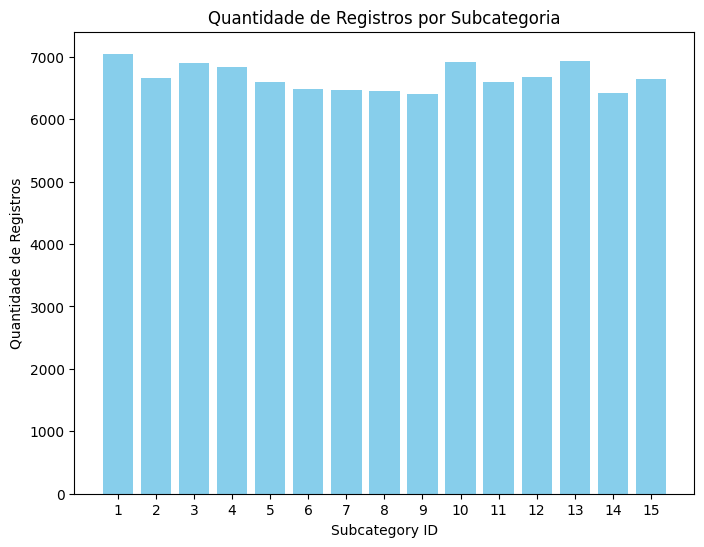

In [206]:
subcategory_counts = simulated_data['Subcategory_ID'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(subcategory_counts.index, subcategory_counts.values, color = 'skyblue')
plt.xlabel('Subcategory ID')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Subcategoria')
plt.xticks(subcategory_counts.index)
plt.show()

### Visualização de Usuário Aleatório

In [207]:
random_user1 = random.randint(1, num_users)
simulated_data[simulated_data['User_ID'] == random_user1]

,User_ID,Subcategory_ID,Current_Timestamp,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
36200,725,3,2024-03-01 11:04:00,3,1,11,4,4
36201,725,9,2024-03-02 19:54:00,3,2,19,54,5
36202,725,2,2024-03-06 02:28:00,3,6,2,28,2
36203,725,15,2024-03-07 21:16:00,3,7,21,16,3
36204,725,15,2024-03-10 23:12:00,3,10,23,12,6
36205,725,15,2024-03-14 08:00:00,3,14,8,0,3
36206,725,3,2024-03-16 01:54:00,3,16,1,54,5
36207,725,9,2024-03-17 12:32:00,3,17,12,32,6
36208,725,15,2024-03-19 22:45:00,3,19,22,45,1
36209,725,6,2024-03-23 04:48:00,3,23,4,48,5


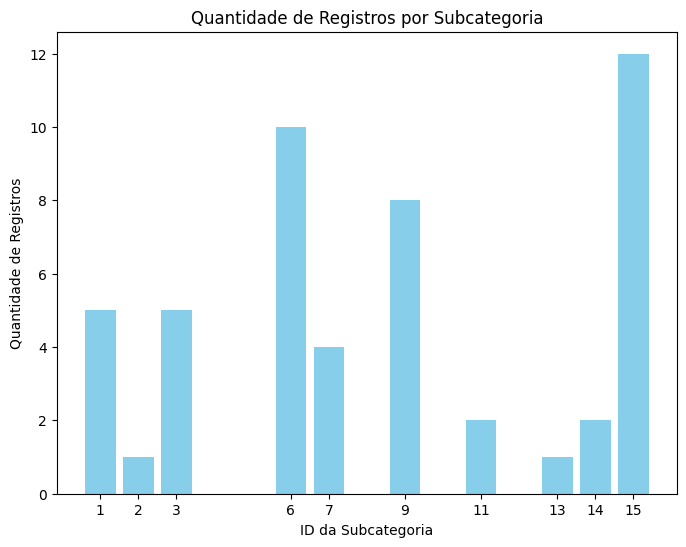

In [208]:
subcategory_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Subcategory_ID'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(subcategory_counts.index, subcategory_counts.values, color = 'skyblue')
plt.xlabel('ID da Subcategoria')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Subcategoria')
plt.xticks(subcategory_counts.index)
plt.show()

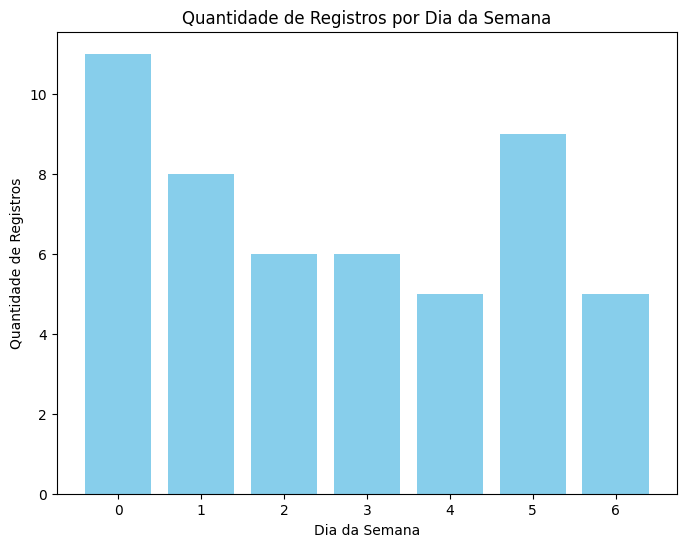

In [209]:
day_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Day_of_Week'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(day_counts.index, day_counts.values, color = 'skyblue')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Dia da Semana')
plt.xticks(day_counts.index)
plt.show()

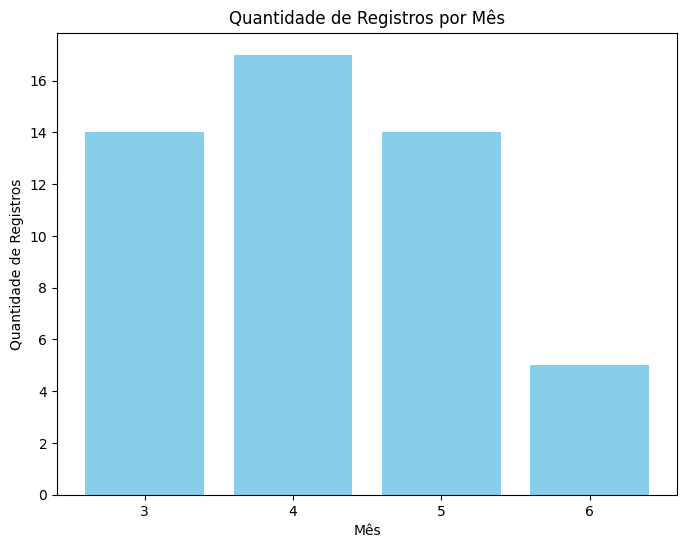

In [210]:
month_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Month'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(month_counts.index, month_counts.values, color = 'skyblue')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Mês')
plt.xticks(month_counts.index)
plt.show()

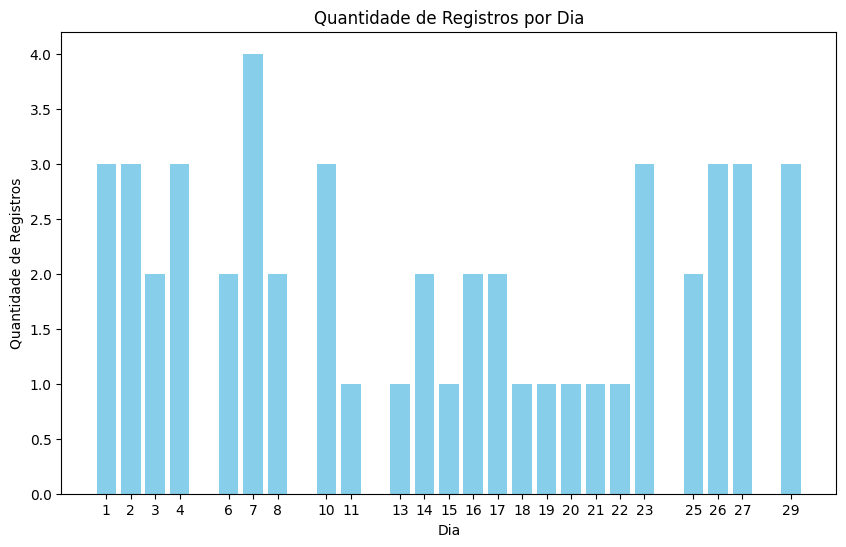

In [211]:
day_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Day'].value_counts()

plt.figure(figsize = (10, 6))
plt.bar(day_counts.index, day_counts.values, color = 'skyblue')
plt.xlabel('Dia')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Dia')
plt.xticks(day_counts.index)
plt.show()

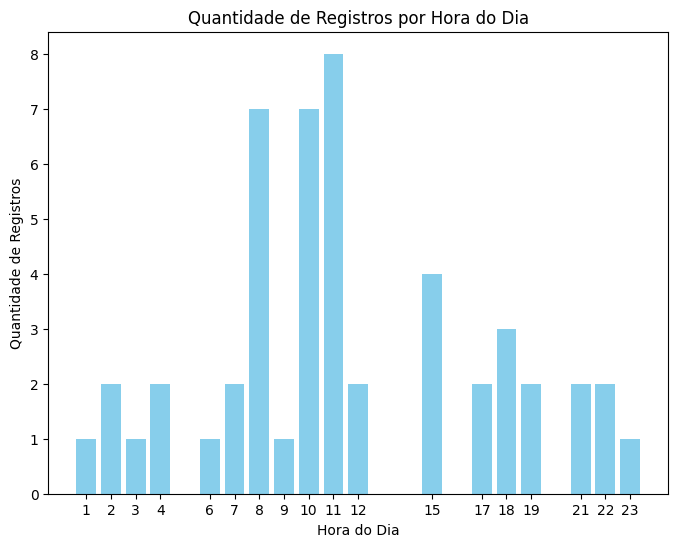

In [212]:
hour_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Hour'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(hour_counts.index, hour_counts.values, color = 'skyblue')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Hora do Dia')
plt.xticks(hour_counts.index)
plt.show()

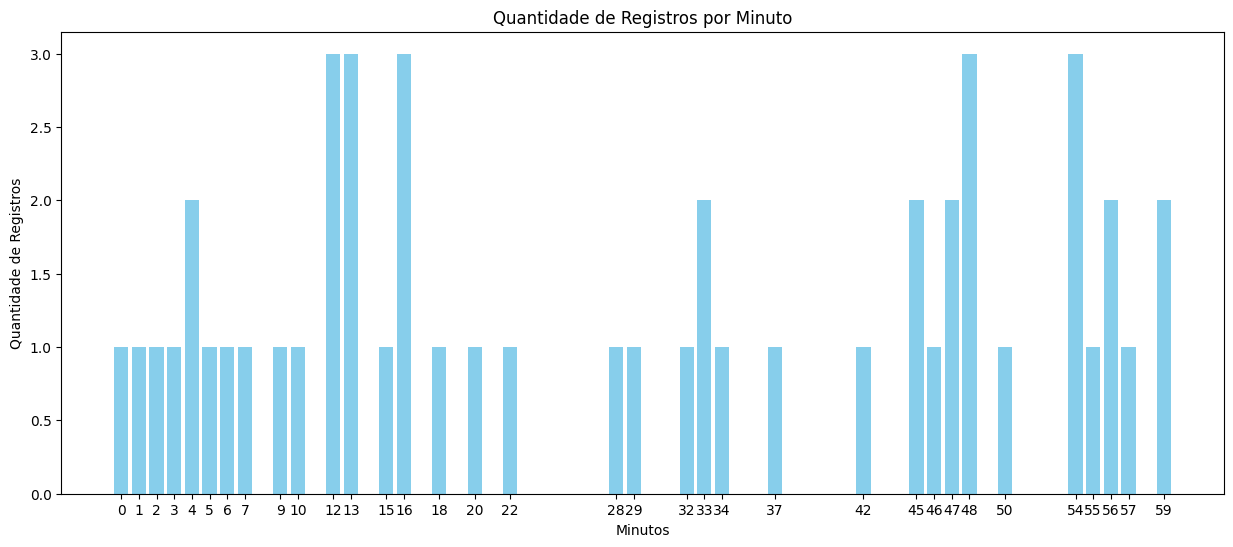

In [213]:
minute_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Time_Component_Minute'].value_counts()

plt.figure(figsize = (15, 6))
plt.bar(minute_counts.index, minute_counts.values, color = 'skyblue')
plt.xlabel('Minutos')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Minuto')
plt.xticks(minute_counts.index)
plt.show()

### Exportação da Base de Dados

In [214]:
simulated_data.to_csv('simulated_data.csv', index = False)

## Tratamento da Base de Dados para Ingestão do Modelo

### Importação das Bibliotecas

In [215]:
!pip install tensorflow

In [216]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [217]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importação da Base de Dados

In [218]:
db = pd.read_csv('/content/simulated_data.csv')
db

,User_ID,Subcategory_ID,Current_Timestamp,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,3,2024-03-01 19:17:00,3,1,19,17,4
1,1,1,2024-03-02 06:26:00,3,2,6,26,5
2,1,15,2024-03-03 11:45:00,3,3,11,45,6
3,1,5,2024-03-06 22:09:00,3,6,22,9,2
4,1,6,2024-03-08 18:48:00,3,8,18,48,4
...,...,...,...,...,...,...,...,...
99995,2000,13,2024-06-01 17:38:00,6,1,17,38,5
99996,2000,9,2024-06-04 09:21:00,6,4,9,21,1
99997,2000,15,2024-06-06 21:40:00,6,6,21,40,3
99998,2000,9,2024-06-08 09:36:00,6,8,9,36,5


### Tratamento de Valores Irrelevantes

In [219]:
db = db.drop('Current_Timestamp', axis = 1)
db.head(1)

,User_ID,Subcategory_ID,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,3,3,1,19,17,4


### Normalização dos Dados

In [220]:
scaler = MinMaxScaler()
db[['Subcategory_ID', 'Time_Component_Month', 'Time_Component_Day', 'Time_Component_Hour', 'Time_Component_Minute', 'Time_Component_Day_of_Week']] = scaler.fit_transform(db[['Subcategory_ID', 'Time_Component_Month', 'Time_Component_Day', 'Time_Component_Hour', 'Time_Component_Minute', 'Time_Component_Day_of_Week']])
db.head(10)

,User_ID,Subcategory_ID,Time_Component_Month,Time_Component_Day,Time_Component_Hour,Time_Component_Minute,Time_Component_Day_of_Week
0,1,0.142857,0.0,0.000000,0.826087,0.288136,0.666667
1,1,0.000000,0.0,0.033333,0.260870,0.440678,0.833333
2,1,1.000000,0.0,0.066667,0.478261,0.762712,1.000000
3,1,0.285714,0.0,0.166667,0.956522,0.152542,0.333333
4,1,0.357143,0.0,0.233333,0.782609,0.813559,0.666667
5,1,0.214286,0.0,0.333333,0.652174,0.525424,0.000000
6,1,0.000000,0.0,0.400000,0.478261,0.203390,0.333333
7,1,0.285714,0.0,0.466667,1.000000,0.864407,0.666667
8,1,0.214286,0.0,0.533333,0.739130,0.508475,1.000000
9,1,0.214286,0.0,0.633333,0.695652,0.932203,0.333333


### Criação de Sequências Temporais

In [221]:
def create_sequences(data, n_steps):
  X, y = [], []
  for i in range(len(data) - n_steps):
    X.append(data[i : i + n_steps])
    y.append(data[i + n_steps])
  return np.array(X), np.array(y)

X_all, y_all = [], []

for user_id in db['User_ID'].unique():
  user_data = db[db['User_ID'] == user_id].drop('User_ID', axis = 1).values
  n_steps = 5
  X, y = create_sequences(user_data, n_steps)

  X_all.append(X)
  y_all.append(y)

X_all = np.concatenate(X_all, axis = 0)
y_all = np.concatenate(y_all, axis = 0)
print(X_all.shape)
print(y_all.shape)

(90000, 5, 6)
(90000, 6)


### Redimensionamento dos Dados

In [222]:
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], X_all.shape[2]))
print(X_all.shape)

y_all = y_all[:, 0]
y_all = y_all.reshape(-1, 1)
print(y_all.shape)

(90000, 5, 6)
(90000, 1)


### Divisão dos Dados entre Treinamento e Teste

In [223]:
# X_train, X_test, y_train, y_test = train_test_split()

# Descrição dos Estudos

## Resumo do Estudo 01

Ao iniciar as pesquisas sobre o treinamento e a implementação de uma rede neural recorrente (RNN) para rastrear e prever os acessos de usuários às subcategorias de um portal de notícias, descobriu-se que o modelo LSTM é adequado para lidar com dados sequenciais e capturar dependências temporais em longas sequências de dados.
O Estudo 01 teve como intuito estabelecer uma base de dados fictícia adequada para o treinamento do modelo LSTM. Contudo, a base de dados gerada se mostrou ineficaz ao modelo, já que não representa os eventos temporais tão significativamente como deveria.

## Resumo do Estudo 02

Dada a ineficácia da base de dados simulada criada no Estudo 01, o objetivo do Estudo 02 foi gerar uma base de dados eficaz e balanceada para o treinamento do modelo LSTM. Neste Estudo, criou-se uma função para gerar registros aleatórios, porém, com variações probabilísticas em intervalos que representam o padrão de comportamento do usuário. Além de sessões dedicadas à visualização da base de dados e usuários para confirmação de sua eficácia. Mais adiante no Estudo 02, é iniciado o Tratamento da mesma base para a etapa posterior de Ingestão de Dados do modelo.

## Resumo do Estudo 03

Após o resultado satisfatório do Estudo 02, o Estudo 03 seguiu com o Tratamento dos dados para o Treinamento do modelo LSTM. Neste Estudo, no decorrer do tratamento foram identificados pontos de melhoria na geração da base de dados, como a separação da coluna de registro temporal em componentes temporais. Além disso, foram executados processos cruciais para a preparação do modelo, como a remoção de colunas irrelevantes para o processo de aprendizagem de máquina, a normalização dos dados para garantir que sua escala semelhante facilite o processo de aprendizagem e evite um modelo enviesado, a criação de sequências que representam basicamente a ordem cronológica dos registros para o modelo, o redimensionamento dos dados para garantir que os dados de entrada tenham as características necessárias para o treinamento de uma LSTM (samples, time_steps, features) e a coluna de saída esteja definida (Subcategory_ID), por fim, o início da divisão entre treinamento e teste, processo este que não foi concluído neste Estudo por dificuldades encontradas na manutenção da cronologia dos registros individuais dos usuários.